> # 공통 환경 처리

In [10]:
%pip install influxdb_client

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import pandas as pd
import glob
from influxdb_client import InfluxDBClient
from datetime import datetime, timedelta
import matplotlib as mpl

# 한글 폰트 설정
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

### Influx DB 접속 정보 및 장치 위치 맵핑 정보

In [12]:
# InfluxDB 설정 정보
url = "http://133.186.144.22:8086"
token = "BPJ1pnKvoaov4Tte971t0zpRSTUXNZvrshU7u3UPheAIsBeUJEFfbKjfsZjtwZmugkHJEGRW17lH4bR9ybanNQ=="
org = "smoothing"

# 디바이스 ID와 위치를 매핑
location_mapping = {
    '24e124126d152919': 'indoor',
    '24e124126d152969': 'bottom_right_corner',
    '24e124128c067999': 'indoor',
    '24e124785c389818': 'bottom_left_corner',
    '24e124785c421885': 'top_right_corner'
}

> # 데이터 집계 함수

influx DB에서 데이터를 받아와 Time, Value, Place, Location, Device 컬럼 형태로 지정을 하였다.

또한 전력 데이터와 온도 데이터를 받을 예정이다.

In [13]:
# InfluxDB 클라이언트 생성
def create_client(url, token, org):
    return InfluxDBClient(url=url, token=token, org=org)

# 쿼리 실행 및 DataFrame으로 변환
def query_to_dataframe(client, query):
    result = client.query_api().query(query=query)
    results = []
    
    for table in result:
        for record in table.records:
            results.append({
                "time": record.get_time(),
                "value": record.get_value(),
                "place": record.values.get("place"),
                "location": record.values.get("location"),
                "device": record.values.get("device")
            })
    
    df = pd.DataFrame(results)
    df['time'] = df['time'].astype(str).str.replace(r'\+00:00$', '', regex=True)
    return df

# 데이터를 날짜를 지정하여 CSV 파일로 저장
def save_csv(df, file_pattern, directory):
    # 경로가 존재하는지 확인하고, 없다면 생성
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    current_date = datetime.now()
    previous_date = current_date - timedelta(days=1)
    filename = f"{directory}{previous_date.strftime(file_pattern)}"
    df.to_csv(filename, index=False)
    
# 온도 Data에서 'device' 열에 따라 'location' 열을 업데이트    
def update_location(df, location_mapping):
    df['location'] = df['device'].map(location_mapping)
    return df

### 각 데이터 조회 및 CSV변환 수행

In [14]:
# 클라이언트 생성 및 쿼리 실행
client = create_client(url, token, org)

# 전력 조회 Flux 쿼리
query_powermetrics = '''
import "date"

from(bucket: "powermetrics_data")
  |> range(start: date.sub(d: 1d, from: date.truncate(t: now(), unit: 1d)), stop: date.truncate(t: now(), unit: 1d))
  |> filter(fn: (r) => r["phase"] == "total")
  |> filter(fn: (r) => r["description"] == "w")
  |> filter(fn: (r) => r["place"] == "class_a" or r["place"] == "office")
  |> filter(fn: (r) => r["location"] != "main")
  |> aggregateWindow(every: 2m, fn: mean, createEmpty: false)
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# CSV 변환
df_powermetrics = query_to_dataframe(client, query_powermetrics)
print(df_powermetrics.head())
save_csv(df_powermetrics, "%m_%d_powermetrics_data.csv", "powermetrics/")


# 온도 조회 Flux 쿼리
query_environmental = '''
import "date"
from(bucket: "environmentalsensors_data")
  |> range(start: date.sub(d: 1d, from: date.truncate(t: now(), unit: 1d)), stop: date.truncate(t: now(), unit: 1d))
  |> filter(fn: (r) => r["measurement"] == "temperature")
  |> filter(fn: (r) => r["place"] == "class_a" or r["place"] == "office")
  |> aggregateWindow(every: 2m, fn: mean, createEmpty: false)
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# CSV 변환
df_environmental = query_to_dataframe(client, query_environmental)
df_environmental_fix = update_location(df_environmental, location_mapping)
print(df_environmental_fix.head())
save_csv(df_environmental_fix, "%m_%d_environmentalsensors_data.csv", "environmentalsensors/")

# 클라이언트 종료
client.close()

                  time  value   place   location     device
0  2024-04-27 00:02:00   29.5  office  a_project  gems-3500
1  2024-04-27 00:04:00   28.0  office  a_project  gems-3500
2  2024-04-27 00:06:00   28.0  office  a_project  gems-3500
3  2024-04-27 00:08:00   28.0  office  a_project  gems-3500
4  2024-04-27 00:10:00   28.0  office  a_project  gems-3500
                  time  value   place location            device
0  2024-04-27 00:02:00   24.2  office   indoor  24e124126d152919
1  2024-04-27 00:04:00   24.3  office   indoor  24e124126d152919
2  2024-04-27 00:06:00   24.3  office   indoor  24e124126d152919
3  2024-04-27 00:08:00   24.4  office   indoor  24e124126d152919
4  2024-04-27 00:10:00   24.4  office   indoor  24e124126d152919


> # 데이터 전처리

데이터 전처리를 위해 결측치 제거와 이상치 제거를 할 것이다.

온도데이터와, 전력데이터 빈값이 있을 수 있으므로 결측치를 제거한다.

이상치는 어떠한 것을 위해 제거한다.

### 전체 데이터 병합 및 결측치 처리 함수

In [15]:
# 전체 데이터 병합
def merge_data(directory_path, file_name):
    # 디렉토리 내의 모든 CSV 파일 목록을 생성
    csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

    # 모든 CSV 파일을 데이터 프레임으로 읽어와 하나로 병합
    data_frames = []
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path)
        df['time'] = pd.to_datetime(df['time'])
        data_frames.append(df)

    # 모든 데이터 프레임을 하나로 병합
    merged_df = pd.concat(data_frames, ignore_index=True)

    # 원하는 컬럼만 선택
    columns_to_keep = ['time', 'value', 'place', 'location']
    filtered_df = merged_df[columns_to_keep]

    # 'place', 'time'으로 정렬
    sorted_df = filtered_df.sort_values(['place', 'time'])

    # 결과 데이터 프레임을 CSV 파일로 저장
    sorted_df.to_csv(file_name, index=False)

    return sorted_df

# 결측치 확인 및 처리
def load_and_clean_data(df, output_directory_path, file_name):
    # 요약 사전 초기화
    file_summary = {}

    # 데이터프레임의 초기 형태 저장
    initial_shape = df.shape

    # 정리 전 총 결측치 수 계산
    missing_before = df.isnull().sum().sum()

    # 결측치 제거
    df.dropna(inplace=True)

    # 정리 후 결측치가 제거되었는지 확인하기 위해 결측치 수 다시 계산
    missing_after = df.isnull().sum().sum()

    # 요약 사전 업데이트
    file_summary["file"] = file_name
    file_summary["initial_rows"] = initial_shape[0]
    file_summary["final_rows"] = df.shape[0]
    file_summary["missing_removed"] = missing_before - missing_after

    # 출력 디렉토리가 존재하지 않는 경우 생성
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)

    # 출력 파일 경로 구성
    output_file_path = os.path.join(output_directory_path, f"{file_name}_cleaned.csv")

    # 정리된 데이터프레임을 CSV로 저장
    df.to_csv(output_file_path, index=False)

    # 처리 결과 요약 출력
    print("\n--- 처리 결과 요약 ---\n")
    print(f"파일 이름: {file_summary['file']}, 초기 행 수: {file_summary['initial_rows']}, 최종 행 수: {file_summary['final_rows']}, 제거된 결측치 수: {file_summary['missing_removed']}")
    print("")

### 각 데이터 병합 수행 및 결측치 처리

In [16]:
powermetrics_path = 'powermetrics'
file_name = 'powermetrics_stats.csv'
stats_values_df = merge_data(powermetrics_path, file_name)
print(stats_values_df.head())
load_and_clean_data(stats_values_df, "cleaned_data/powermetrics/", "powermetrics_stats")

environmentalsensors_path = 'environmentalsensors'
file_name = 'environmentalsensors_stats.csv'
stats_values_df = merge_data(environmentalsensors_path, file_name)
print(stats_values_df.head())
load_and_clean_data(stats_values_df, "cleaned_data/environmentalsensors/", "environmentalsensors_stats")

                     time  value    place                 location
40183 2024-04-15 00:02:00   23.5  class_a           ac_indoor_unit
41623 2024-04-15 00:02:00  112.5  class_a          ac_outdoor_unit
43783 2024-04-15 00:02:00    8.0  class_a           automatic_door
53143 2024-04-15 00:02:00    0.0  class_a  outdoor_unit_room_light
40184 2024-04-15 00:04:00   23.5  class_a           ac_indoor_unit

--- 처리 결과 요약 ---

파일 이름: powermetrics_stats, 초기 행 수: 232896, 최종 행 수: 232896, 제거된 결측치 수: 0

                     time  value    place             location
18242 2024-04-15 00:02:00  23.10  class_a  bottom_right_corner
18948 2024-04-15 00:02:00  23.85  class_a               indoor
19668 2024-04-15 00:02:00  23.50  class_a   bottom_left_corner
20388 2024-04-15 00:02:00  23.40  class_a     top_right_corner
18243 2024-04-15 00:04:00  23.20  class_a  bottom_right_corner

--- 처리 결과 요약 ---

파일 이름: environmentalsensors_stats, 초기 행 수: 35366, 최종 행 수: 35366, 제거된 결측치 수: 0



> ### 전력, 온도 데이터의 연관 관계 측정

전력과 온도 데이터를 가지고 연관관계를 측정 해볼 것이다. 

조건은 평균 전력 사용량과 평균 온도를 계산하며 두 데이터 프레임을 시간대 기준으로 결합을 할 것이다. 이후 상관관계에 대해서 수치를 나타내어 확인을 해볼 것이다.

In [20]:
# 전력 사용량 데이터와 환경 센서 데이터를 로드합니다.
environmentalsensors_df = pd.read_csv('cleaned_data/environmentalsensors/environmentalsensors_stats_cleaned.csv')
powermetrics_df = pd.read_csv('cleaned_data/powermetrics/powermetrics_stats_cleaned.csv')

# 시간대별로 그룹화하여 각 시간대의 평균 전력 사용량을 계산합니다.
power_avg = powermetrics_df.groupby('time').value.mean().reset_index(name='avg_power_usage')

# 시간대별로 그룹화하여 각 시간대의 평균 온도를 계산합니다.
temp_avg = environmentalsensors_df.groupby('time').value.mean().reset_index(name='avg_temperature')

# 두 데이터프레임을 시간대(time_hour_min)를 기준으로 결합합니다.
combined_data = pd.merge(power_avg, temp_avg, on='time')

# 상관관계 계산
correlation = combined_data[['avg_power_usage', 'avg_temperature']].corr()

# 상관관계 출력
print(correlation)

                 avg_power_usage  avg_temperature
avg_power_usage         1.000000         0.447963
avg_temperature         0.447963         1.000000


In [19]:
import pandas as pd

# 전력 사용 데이터와 환경 센서 데이터 로드하기.
environmentalsensors_df = pd.read_csv('cleaned_data/environmentalsensors/environmentalsensors_stats_cleaned.csv')
powermetrics_df = pd.read_csv('cleaned_data/powermetrics/powermetrics_stats_cleaned.csv')

# 이상치 제거 함수 (z-score 사용)
def remove_outliers_by_zscore(df, column_name, z_thresh):
    # 열의 z-score 계산
    df['z_score'] = zscore(df[column_name])
    # z-score가 임계값 이내인 데이터만 필터링
    return df[df['z_score'].abs() <= z_thresh].drop(columns=['z_score'])

# 각 데이터 세트에 z-score 이상치 제거 적용
powermetrics_df = remove_outliers_by_zscore(powermetrics_df, 'value', 2.4)
environmentalsensors_df = remove_outliers_by_zscore(environmentalsensors_df, 'value', 2.4)

# 시간 기간별로 그룹화하고 각 시간 기간에 대한 평균 전력 사용량 계산
power_avg = powermetrics_df.groupby('time').value.mean().reset_index(name='avg_power_usage')

# 시간 기간별로 그룹화하고 각 시간 기간에 대한 평균 온도 계산
temp_avg = environmentalsensors_df.groupby('time').value.mean().reset_index(name='avg_temperature')

# 시간대(time_hour_min)를 기준으로 두 데이터 프레임 결합
combined_data = pd.merge(power_avg, temp_avg, on='time')

# 상관 관계 계산
correlation = combined_data[['avg_power_usage', 'avg_temperature']].corr()

# 상관계수 출력
print("온도와 전력 사용 사이의 상관계수는 다음과 같습니다:")
print(correlation)

NameError: name 'zscore' is not defined

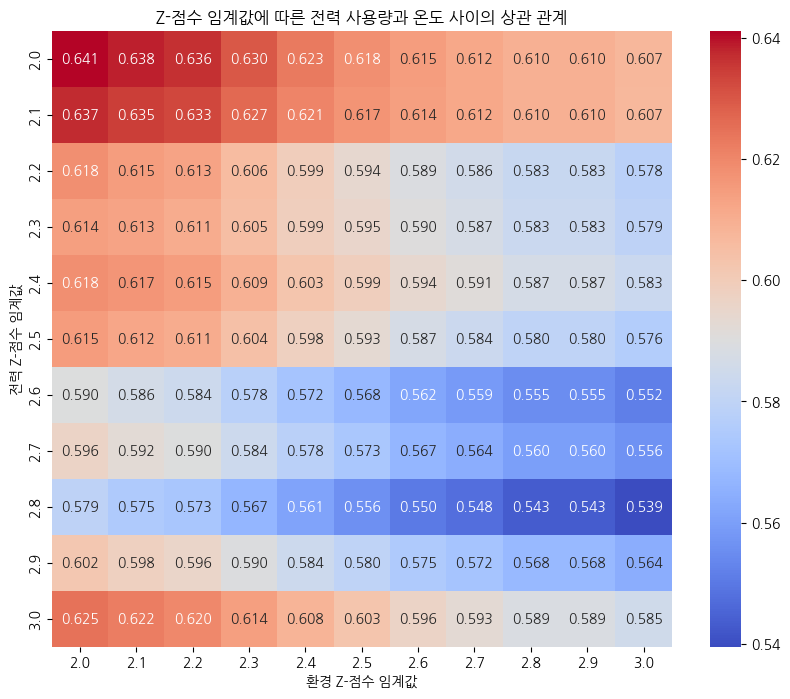

In [21]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드
environmentalsensors_df = pd.read_csv('cleaned_data/environmentalsensors/environmentalsensors_stats_cleaned.csv')
powermetrics_df = pd.read_csv('cleaned_data/powermetrics/powermetrics_stats_cleaned.csv')

# 이상치 제거 함수 (z-점수 사용)
def remove_outliers_by_zscore(df, column_name, z_thresh):
    df['z_score'] = zscore(df[column_name])
    return df[np.abs(df['z_score']) <= z_thresh].drop(columns=['z_score'])

# 각 데이터 세트에 대한 Z-점수 임계값 범위 지정
z_thresh_range_power = np.linspace(2.0, 3.0, 11)
z_thresh_range_env = np.linspace(2.0, 3.0, 11)

# 상관관계를 저장할 딕셔너리
correlation_results = {}

# 모든 조합의 z-점수 임계값에 대해 반복
for z_power in z_thresh_range_power:
    for z_env in z_thresh_range_env:
        # 이상치 제거
        temp_filtered_df = remove_outliers_by_zscore(environmentalsensors_df, 'value', z_env)
        power_filtered_df = remove_outliers_by_zscore(powermetrics_df, 'value', z_power)

        # 시간별 그룹으로 평균값 계산
        temp_avg = temp_filtered_df.groupby('time').value.mean().reset_index(name='avg_temperature')
        power_avg = power_filtered_df.groupby('time').value.mean().reset_index(name='avg_power_usage')

        # 데이터 프레임을 시간 기준으로 결합
        combined_data = pd.merge(temp_avg, power_avg, on='time')

        # 상관관계 계산
        correlation = combined_data[['avg_temperature', 'avg_power_usage']].corr().iloc[0, 1]
        correlation_results[(z_power, z_env)] = correlation

# 히트맵 데이터를 배열로 변환
correlation_matrix = np.array([[correlation_results[(z_power, z_env)] for z_env in z_thresh_range_env] for z_power in z_thresh_range_power])

# 히트맵 생성
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f",
            xticklabels=np.round(z_thresh_range_env, 1),
            yticklabels=np.round(z_thresh_range_power, 1))
plt.title('Z-점수 임계값에 따른 전력 사용량과 온도 사이의 상관 관계')
plt.xlabel('환경 Z-점수 임계값')
plt.ylabel('전력 Z-점수 임계값')
plt.show()

In [22]:
# 가장 높은 상관관계 점수 찾기
max_correlation_value = max(correlation_results.values())

# 해당 상관관계 점수에 해당하는 z-점수 임계값 찾기
max_correlation_thresholds = [thresholds for thresholds, correlation in correlation_results.items() if correlation == max_correlation_value]

# 결과 출력
print(f"최대 상관관계 점수: {max_correlation_value * 100:.2f}%")
print(f"해당 점수를 가진 Z-점수 임계값 조합: {max_correlation_thresholds}")

최대 상관관계 점수: 64.10%
해당 점수를 가진 Z-점수 임계값 조합: [(2.0, 2.0)]
